In [20]:
import torch 
from torch import nn
from torch.utils.data import random_split
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

In [5]:
Xtr, Xte = [], []
Ytr, Yte = [], []

def shift_vertical(data): 
    """shift the dataset up by 1 pixel. data is a tensor of shape (X, 1, 16, 16)"""
    data_shift = -1 * torch.ones(data.shape)
    data_shift[:, :, 0:-1, :] = data[:, :, 1:, :]
    return data_shift
    
def shift_horizontal(data): 
    """shift the dataset right by 1 pixel. data is a tensor of shape (X, 1, 16, 16)"""
    data_shift = -1 * torch.ones(data.shape)
    data_shift[:, :, :, 0:-1] = data[:, :, :, 1:]
    return data_shift
    
with open("dataset/zip.train", 'r') as f: 
    dataset = f.read().splitlines()
    for data in dataset: 
        data = data.split()
        Ytr.append(int(float(data[0])))
        Xtr.append([float(d) for d in data[1:]])
    Ytr = torch.tensor(Ytr)
    Xtr = torch.tensor(Xtr)
    Xtr = Xtr.view(Xtr.shape[0], 1, 16, 16)               # format as a 4D column as expected by Conv2d
    
    # augment data by translating existing dataset
#     Xtr_shift_up = shift_vertical(Xtr)
#     Xtr_shift_left = shift_horizontal(Xtr)
#     Xtr = torch.cat((Xtr, Xtr_shift_up, Xtr_shift_left), 0)
#     Ytr = torch.cat((Ytr, Ytr, Ytr), 0)
    
with open("dataset/zip.test", "r") as f: 
    dataset = f.read().splitlines()
    for data in dataset: 
        data = data.split()
        Yte.append(int(float(data[0])))
        Xte.append([float(d) for d in data[1:]])
    Yte = torch.tensor(Yte)
    Xte = torch.tensor(Xte)
    Xte = Xte.view(Xte.shape[0], 1, 16, 16)   # format as a 4D column as expected by Conv2d

print(f"Training Data Length = {len(Xtr)}, Test Data Length = {len(Xte)}")

Training Data Length = 7291, Test Data Length = 2007


Examples from the Training Set


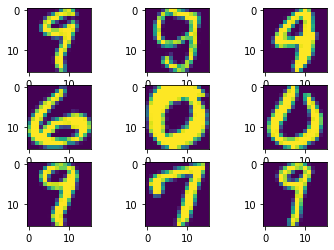

In [6]:
print("Examples from the Training Set")
fig, axs = plt.subplots(3,3)
ix = torch.randint(0, Xtr.shape[0], (9, ))
i = 0
for row in axs: 
    for col in row: 
        col.imshow(Xtr[ix[i]].squeeze())
        i += 1

In [291]:
# Define Class for the LeNet architecture 

class LeNet(nn.Module):  
    def __init__(self, num_channels, classes): 
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=12, kernel_size=(5, 5), stride=1, padding=2, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(5,5), stride=1, padding=2, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(num_features=12)
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
        
        self.fc1 = nn.Linear(in_features=12*14*14, out_features=30, bias=False)
        self.batchnorm3 = nn.BatchNorm1d(num_features=30)
        self.relu3 = nn.ReLU() 
        
        self.fc2 = nn.Linear(in_features=30, out_features=classes, bias=True)

    def forward(self, x): 
        x = self.relu1(self.batchnorm1(self.conv1(x)))
        x = self.relu2(self.batchnorm2(self.conv2(x)))
        x = self.maxpool1(x) 

        x = x.flatten(start_dim=1)
        x = self.relu3(self.batchnorm3(self.fc1(x)))
        x = self.fc2(x)
        return x 
    
#     def _init_weights(self, module): 
#         print(module)
#         if isinstance(module, nn.Conv2d): 
#             module.weights.
        

In [137]:
# import modules used to visualize and analyze data
from sklearn.metrics import classification_report
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.optim import Adam
import time
import numpy as np

In [292]:
# Define initial hyperparameters
lr = 1e-3 
beta1 = 0.9
beta2 = 0.999
eps = 1e-8

BATCH_SIZE = 64
REG = 1e-3
VAL_SPLIT = 0.2
TRAIN_SPLIT = 1 - VAL_SPLIT
NUM_EPOCHS = 10

g = torch.manual_seed(1234)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [172]:
# Download the Data and create Data Loaders

trainData = MNIST(root="MNIST_data", train=True, download=True, transform=ToTensor())
testData = MNIST(root="MNIST_data", train=False, download=True, transform=ToTensor())

# creating validation split 
(trainData, valData) = random_split(trainData, [TRAIN_SPLIT, VAL_SPLIT], generator=g)
trainLoader = DataLoader(dataset=trainData, batch_size=BATCH_SIZE, shuffle=True)
valLoader = DataLoader(dataset=valData, batch_size=BATCH_SIZE, shuffle=False)
testLoader = DataLoader(dataset=testData, batch_size=BATCH_SIZE)

# number of iterations/epoch 
train_steps = len(trainLoader.dataset)//BATCH_SIZE
val_steps = len(valLoader.dataset)//BATCH_SIZE
test_steps = len(testLoader.dataset)//BATCH_SIZE


In [435]:
# Initialize the model and optimizer
model = LeNet(num_channels=1, classes=len(trainData.dataset.classes)).to(device)
opt = Adam(params=model.parameters(), lr=lr, betas=(beta1, beta2), eps=eps)
lossfn = nn.CrossEntropyLoss()

# Arrays to Track Info 
H = {
    'trainLoss': [],
    'trainAcc': [],
    'valLoss': [],
    'valAcc': []
}

# Define hooks so that we can examine intermediate activations and gradients 

activations = {}
gradients = {}

def forward_hook(name):
    def hook(module, args, output): 
        activations[name] = output.detach()
    return hook

def backward_hook(name): 
    def hook(module, grad_input, grad_output):
        gradients[name] = grad_output
    return hook

for name, layer in model.named_children(): 
    layer.register_forward_hook(forward_hook(name))
    layer.register_full_backward_hook(backward_hook(name))

In [436]:
# train 
startTime = time.time()
ud = []

for epoch in range(NUM_EPOCHS): 
    
    # set the model to train mode
    model.train() 
    
    # crate variables to track total loss and accuracy 
    init = 1
    lossi = 0
    totalTrainLoss = 0
    totalValLoss = 0
    
    trainCorrect = 0
    valCorrect = 0
    i = 0
    
    # train
    for (x, y) in trainLoader: 
        logits = model(x)
        lossi = lossfn(logits, y) 
        y_pred = logits.argmax(dim=1)
        if (epoch == 0 and init): 
            print(f"Initial Loss = {lossi}")
            init = 0

        # track accuracies and losses
        totalTrainLoss += lossi 
        trainCorrect += torch.sum(y_pred == y)
        
        # backprop and update
        init_params = {name: p.clone().detach() for name, p in model.named_parameters()}
        opt.zero_grad()
        lossi.backward()
        opt.step()
        final_params = {name: p.clone().detach() for name, p in model.named_parameters()}
        
        ud.append({name: ((final_params[name] - init_params[name]).std()/((init_params[name]).std())).log10().item() for name in init_params})
        i += 1

    # eval with validation data
    with torch.no_grad(): 
        model.eval()
        for (x, y) in valLoader:
            logits = model(x)
            lossi = lossfn(logits, y) 
            y_pred = logits.argmax(dim=1)
            
            totalValLoss += lossi
            valCorrect += torch.sum(y_pred == y)
        
        # track all stats on a per-epoch basis
        avgTrainLoss = totalTrainLoss / train_steps
        avgValLoss = totalValLoss / val_steps
        trainAcc = trainCorrect / (train_steps * BATCH_SIZE)
        valAcc = valCorrect / (val_steps * BATCH_SIZE)

        H['trainLoss'].append(avgTrainLoss)
        H['valLoss'].append(avgValLoss)
        H['trainAcc'].append(trainAcc)
        H['valAcc'].append(valAcc) 
    
    print(f"epoch {epoch}/{NUM_EPOCHS}: loss = {lossi:.4f} | trainLoss, accuracy = {avgTrainLoss:.4f}, {trainAcc:.4f} | valLoss, accuracy = {avgValLoss:.4f}, {valAcc:.4f}")

stopTime = time.time()
# print(f"Total runtime = {stopTime - startTime}")

Initial Loss = 2.3660004138946533
epoch 0/10: loss = 0.1203 | trainLoss, accuracy = 0.2615, 0.9624 | valLoss, accuracy = 0.0740, 0.9853
epoch 1/10: loss = 0.1103 | trainLoss, accuracy = 0.0528, 0.9864 | valLoss, accuracy = 0.0476, 0.9888
epoch 2/10: loss = 0.0689 | trainLoss, accuracy = 0.0355, 0.9900 | valLoss, accuracy = 0.0395, 0.9911
epoch 3/10: loss = 0.0442 | trainLoss, accuracy = 0.0266, 0.9923 | valLoss, accuracy = 0.0395, 0.9908
epoch 4/10: loss = 0.0675 | trainLoss, accuracy = 0.0215, 0.9937 | valLoss, accuracy = 0.0372, 0.9898
epoch 5/10: loss = 0.0664 | trainLoss, accuracy = 0.0185, 0.9945 | valLoss, accuracy = 0.0368, 0.9913
epoch 6/10: loss = 0.1124 | trainLoss, accuracy = 0.0138, 0.9959 | valLoss, accuracy = 0.0332, 0.9926
epoch 7/10: loss = 0.0784 | trainLoss, accuracy = 0.0119, 0.9964 | valLoss, accuracy = 0.0344, 0.9926
epoch 8/10: loss = 0.0696 | trainLoss, accuracy = 0.0107, 0.9966 | valLoss, accuracy = 0.0380, 0.9907
epoch 9/10: loss = 0.0181 | trainLoss, accuracy 

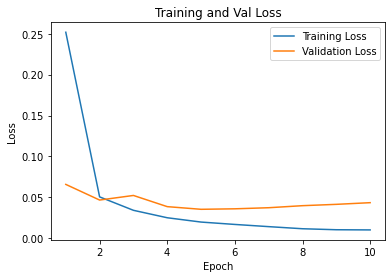

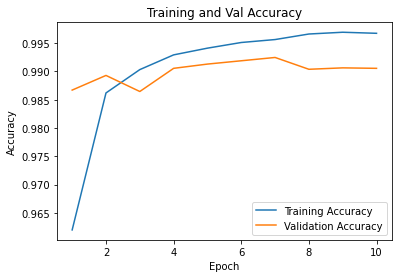

In [348]:
# plot results 

plt.figure()
plt.plot(range(1, 11), H['trainLoss'], label='Training Loss')
plt.plot(range(1, 11), H['valLoss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Val Loss')
plt.legend()

plt.figure()
plt.plot(range(1, 11), H['trainAcc'], label='Training Accuracy')
plt.plot(range(1, 11), H['valAcc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Val Accuracy')
plt.legend()


In [347]:
# save the model and evaluate the entire test set for errors

with torch.no_grad():
    model.eval()
    totalTestLoss = 0
    testTestAcc = 0

    y_true = []
    y_pred = []

    for (x, y) in testLoader: 
        logits = model(x) 
        lossi = lossfn(logits, y)

        y_true += y.tolist()
        y_pred += logits.argmax(1).tolist() 
        totalTestLoss += lossi

averageTestLoss = totalTestLoss / test_steps
testAcc = torch.sum(torch.tensor(y_pred) == torch.tensor(y_true)) / (test_steps * BATCH_SIZE)

errs = sum(np.array(y_true) != np.array(y_pred))
err_rate = errs / len(testLoader.dataset)

print(f"Test Results: Test Loss = {averageTestLoss:.4f}, Errors = {errs}, Error Rate = {err_rate*100}%")
print(classification_report(np.array(y_true), np.array(y_pred), target_names=testData.classes))

Test Results: Test Loss = 0.0378, Errors = 116, Error Rate = 1.16%
              precision    recall  f1-score   support

    0 - zero       0.99      0.99      0.99       980
     1 - one       0.99      1.00      0.99      1135
     2 - two       0.99      0.99      0.99      1032
   3 - three       0.98      0.99      0.99      1010
    4 - four       0.98      0.99      0.99       982
    5 - five       0.99      0.98      0.98       892
     6 - six       0.99      0.98      0.99       958
   7 - seven       0.99      0.98      0.99      1028
   8 - eight       0.98      1.00      0.99       974
    9 - nine       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



<Figure size 432x288 with 0 Axes>

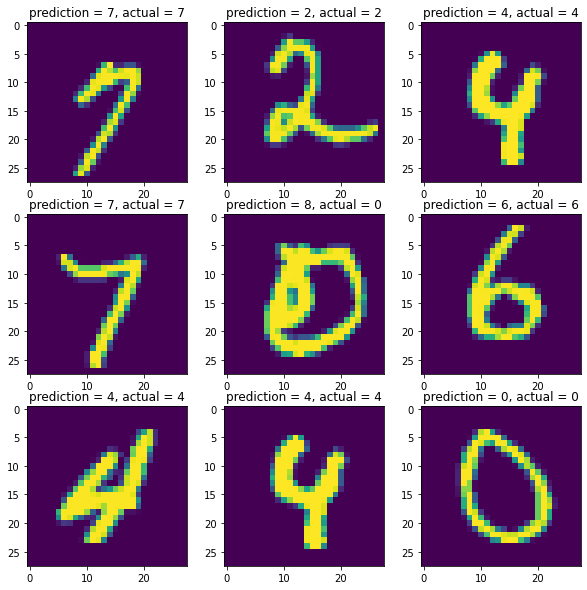

In [143]:
# sample the model of the model
model.eval()

x, y = next(iter(valLoader))

logits = model(x)
probs = logits.softmax(1)
y_pred = torch.max(probs, 1)

idxs = torch.randint(0, BATCH_SIZE, (9, ))

plt.figure()
fig, axs = plt.subplots(3,3)
fig.set_size_inches(10, 10)

for i, ix in enumerate(idxs):
    row = i // 3
    col = i % 3
    axs[row][col].imshow(x[ix].squeeze())
    axs[row][col].title.set_text(f"prediction = {y_pred.indices[ix].item()}, actual = {y[ix]}")
    i += 1



torch.Size([16, 12, 28, 28])
ACTIVATIONS
conv1       | mean: -0.0371 | std: 0.2791 | positive: 0.21
relu1       | mean: 0.2799 | std: 0.4894 | positive: 0.47
conv2       | mean: -1.4117 | std: 1.6360 | positive: 0.15
relu2       | mean: 0.2053 | std: 0.3398 | positive: 0.46
maxpool1    | mean: 0.3166 | std: 0.4363 | positive: 0.59
fc1         | mean: -0.8584 | std: 5.1520 | positive: 0.41
relu3       | mean: 0.9697 | std: 1.3416 | positive: 0.50
fc2         | mean: -4.9325 | std: 5.7826 | positive: 0.11


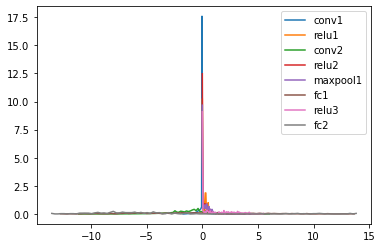

In [350]:
# analyze activations 

print(activations['conv2'].shape)
print("ACTIVATIONS")

for key, value in activations.items(): 
    if not key.startswith('batchnorm'):
        pdf, bin_edges = torch.histogram(value, density=True)
        plt.plot(bin_edges[:-1], pdf, label=key)

        print(f"{key} {' ' * (10 - len(key))} | mean: {value.mean():.4f} | std: {value.std():.4f} | positive: {torch.sum(value > 0)/value.numel():.2f}")

plt.legend()


torch.Size([64, 30])
GRADIENTS
fc2         | mean: -8.73e-12 | std: 7.85e-04
relu3       | mean: 1.28e-05 | std: 1.29e-03
fc1         | mean: -9.70e-13 | std: 6.73e-04
maxpool1    | mean: 2.72e-13 | std: 4.08e-04
relu2       | mean: 3.71e-14 | std: 2.04e-04
conv2       | mean: 5.57e-14 | std: 1.09e-04
relu1       | mean: 1.53e-07 | std: 1.81e-04
conv1       | mean: -1.58e-12 | std: 6.84e-04


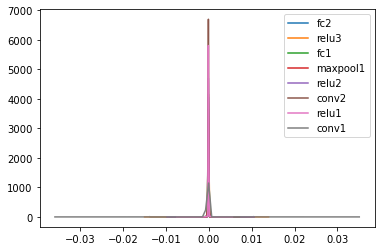

In [351]:
# analyze gradients 

print(gradients['fc1'][0].shape)
print("GRADIENTS")

for key, value in gradients.items(): 
    if not key.startswith('batchnorm'):
        pdf, bin_edges = torch.histogram(value[0], density=True)
        plt.plot(bin_edges[:-1], pdf, label=key)

        print(f"{key} {' ' * (10 - len(key))} | mean: {value[0].mean():.2e} | std: {value[0].std():.2e}")

plt.legend()


Conv2d      | mean: -9.13e-03 | std: 1.41e-01
Conv2d      | mean: -1.77e-02 | std: 8.66e-02
Linear      | mean: -1.33e-03 | std: 7.17e-02
Linear      | mean: -1.71e-01 | std: 4.54e-01
Linear      | mean: 1.26e-02 | std: 1.14e-01


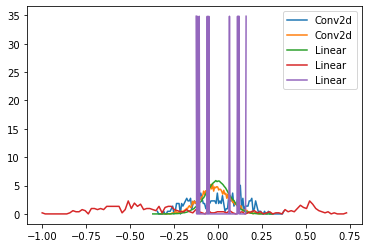

In [352]:
# plot parameters 
for layer in model.children():
    layer_name = layer.__class__.__name__
    if layer_name not in ['BatchNorm2d', 'BatchNorm1d', 'ReLU', 'MaxPool2d']:
        for p in layer.parameters(): 
            pdf, bin_edges = torch.histogram(p.detach(), density=True)
            plt.plot(bin_edges[:-1], pdf, label=layer_name)

            print(f"{layer_name} {' ' * (10 - len(layer_name))} | mean: {p.mean():.2e} | std: {p.std():.2e}")
plt.legend()

Conv2d      | mean: -1.68e-02 | std: 4.24e-02
Conv2d      | mean: -3.97e-04 | std: 1.23e-02
Linear      | mean: -2.76e-06 | std: 1.89e-03
Linear      | mean: -7.45e-11 | std: 1.04e-02


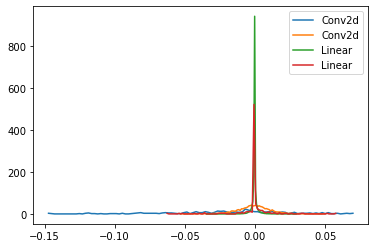

In [440]:
# plot parameter gradients 

for layer in model.children():
    layer_name = layer.__class__.__name__
    if layer_name not in ['BatchNorm2d', 'BatchNorm1d', 'ReLU', 'MaxPool2d']:
        for p in layer.parameters():
                if p.squeeze().ndim >= 2: 
                    t = p.grad
                    pdf, bin_edges = torch.histogram(t, density=True)
                    plt.plot(bin_edges[:-1], pdf, label=layer_name)

                    print(f"{layer_name} {' ' * (10 - len(layer_name))} | mean: {t.mean():.2e} | std: {t.std():.2e}")
plt.legend()

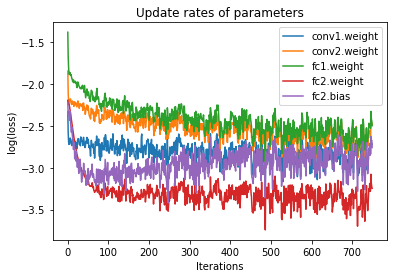

In [439]:
# plot update rates

for name, _ in model.named_parameters(): 
    if 'batchnorm' not in name: 
        rates = [dp[name] for dp in ud]
        mean_rates = torch.tensor(rates).view(-1, 10).mean(1)
        plt.plot(mean_rates, label=name)
        plt.title('Update rates of parameters')
        plt.xlabel('Iterations')
        plt.ylabel('log(loss)')
    
plt.legend()